In [23]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [175]:
class GMDH_layer(keras.layers.Layer):
    
    core_dim = 6
    
    def __init__(self, units, mask, weights=None):
        super(GMDH_layer, self).__init__()
        if weights == None:
            self.w = tf.Variable(
                initial_value=tf.ones_initializer()(shape=(GMDH_layer.core_dim, units), dtype="float32"),
                trainable=True,
            )
        else:
            self.w = weights
        
        self.mask = mask
        self.u=units

    @tf.function
    def call(self, t_inputs):
        """
        t_inputs: N dim вектор
        t_p: N dim вектор
        """
        mask = self.mask
        masked_inputs = tf.TensorArray(tf.float32, size=self.u)
        for i in tf.range(self.u):
            masked_inputs = masked_inputs.write(i, tf.boolean_mask(t_inputs, mask[i]))
        masked_inputs = masked_inputs.stack()
        return tf.reduce_sum(
            tf.multiply(
                tf.eye(self.u), 
                tf.linalg.matmul(
                    binomial_core(masked_inputs), 
                    self.w)
            ), 0)
    
        
    
class Model(keras.layers.Layer):
    
    def __init__(self, inputs, weights = None):
        super(Model, self).__init__()
        self.inputs = [f"i{i}" for i in range(inputs)]
        self.connectivity_graph = {}
        self.layers = []
        self.init_layer(self.inputs, weights)
        
    def init_layer(self, inputs, weights = None):
        com = [(x,y) for x in inputs for y in inputs if x != y]
        m = tf.constant([[1 if i in j else 0 for j in com] for i in inputs])
        layer = GMDH_layer(units = len(com), mask = tf.transpose(m), weights = weights)
        connections = {f"l{len(self.layers)}n{i}": j for i, j in enumerate(com)}
        self.connectivity_graph.update(connections)
        self.layers.append(layer)
    
    def add_layer(self, weights = None):
        prev = [x for x in self.connectivity_graph.keys() if f"l{len(self.layers)-1}" in x]
        com = [(x,y) for x in prev for y in prev if x != y]
        m = tf.constant([[1 if i in j else 0 for j in com] for i in prev])
        layer = GMDH_layer(units = len(com), mask = tf.transpose(m), weights = weights)
        connections = {f"l{len(self.layers)}n{i}": j for i, j in enumerate(com)}
        self.connectivity_graph.update(connections)
        self.layers.append(layer)
          
    def call(self, inputs):
        x = inputs
        for m_l in self.layers:
            x = m_l(x)
        return x        

def invert_graph(graph):
    res = {}
    for key in graph:
        for item in graph[key]:
            if item in res:
                res[item].append(key)
            else:
                res[item] = [key]
    return(res)

@tf.function
def binomial_core(t_inputs):
    """
    t_inputs: N*2 матрица
    res: N*6 матрица
    """
    one = tf.constant(1, shape=(1,), dtype=tf.float32)
    res = tf.TensorArray(tf.float32, size=t_inputs.shape[0])
    for i in tf.range(t_inputs.shape[0]):
        res = res.write(i, 
        tf.concat(
        [
            t_inputs[i][0]**2,
            t_inputs[i][0],
            t_inputs[i][0]*t_inputs[i][1],
            t_inputs[i][1],
            t_inputs[i][1]**2,
            one
        ], axis=0))
    return res.stack()

In [145]:
#tree representation
#after Nikolaev, Iba 1998

import random, functools
from matplotlib import pyplot as plt
import numpy as np

MAX_GENERATIONS = 1000
POPULATION_SIZE = 10
MAX_GRAFT_SIZE = 10
MAX_TREE_SIZE = 35
MAX_ERROR = 100
GOAL = 0.2

WEIGHTS_NUM = 3
TEST_POINTS = 100

class Bunch(dict):
    def __init__(self, *args, **kwds):
        super(Bunch, self).__init__(*args, **kwds)
        self.__dict__ = self
    
    def __call__(self, x):
        i = [0,0]
        if not isinstance(x, list):
            x = list(x)
        if not isinstance(self.left, int):
            i[0] = x[self.left]
        if not isinstance(self.right, int):
            i[1] = x[self.right]
        return self.op(i, self.weights)
    
    def __getitem__(self, key):
        if key == 0:
            return self.left
        elif key == 1:
            return self.right
        else:
            raise IndexError(f"Tree has only 2 branches, can't get branch {key}")

    def __setitem__(self, key, value):
        if key == 0:
            self.left = value
        elif key == 1:
            self.right = value
        else:
            raise IndexError(f"Tree has only 2 branches,  can't set branch {key}")
    
    def __hash__(self):
        return hash(
            str(hash(self.op))
            +str(hash(self.weights))
            +str(hash(self.left))
            +str(hash(self.right))
        )
    
    def __repr__(self):
        return ' '.join(('( l:', str(self.left), 'r:', str(self.right), ')'))
        

ops = (
    lambda x,w:w[0]+w[1]*x[0]+w[2]*x[1],
    lambda x,w:w[0]+w[1]*x[0]+w[2]*x[0]**2*x[1],
    lambda x,w:w[0]+w[1]*x[0]+w[2]*x[0]*x[1]**2,
    lambda x,w:w[0]+w[1]*x[0]+w[2]*x[1]**2,
    lambda x,w:w[0]+w[1]*x[0]+w[2]*x[0]*x[1],
    lambda x,w:w[0]+w[1]*x[0]+w[2]*x[1]**3,
)

def lse(f, points, real):
    """
    normalized RSE of function on test values
    """
    s = 0
    for p, r in zip(points, real):
        s += (f(p)-r)**2
    return s/len(points)

@functools.cache
def calculate_size(tree):
    if isinstance(tree, int):
        return (0, 0)
    else:
        ls, rs = calculate_size(tree.left), calculate_size(tree.right)
        tree.size = ls[0]+rs[0]+1
        tree.order = max((ls[1], rs[1]))+1
        return (tree.size, tree.order)

def gen_node(lr, parent):
    if not isinstance(lr, list):
        lr = list(lr)
    if len(lr) != 2:
        raise IndexException("You need to provide two child nodes!")
    random.shuffle(lr)
    n = Bunch(
        weights = tuple([random.random() for x in range(WEIGHTS_NUM)]), 
        op=random.choice(ops), 
        left = lr[0], 
        right = lr[1],
        parent = parent
    )
    if parent == None:
        n.root = n
    else:
        n.root = parent.root
    calculate_size(n.root)
    return n

def get_branch(tree, n=None):
    if n is None:
        n = random.randint(0, tree.size*2-1)
    
    if isinstance(tree.left, int):
        ls = 0
    else:
        ls = tree.left.size
        
    if isinstance(tree.right, int):
        rs = 0
    else:
        rs = tree.right.size
        
    
        
    
def insert_node(tree):
    b = get_branch(tree)
    n = gen_node((b[0][b[2]], None), b[0])
    b[0][b[2]] = n
    
    calculate_size(tree.root)

def delete_node(tree):
    b = get_branch(tree)
    i = random.randint(0,1)
    if not isinstance(b[1], int):
        if not isinstance(b[1][i], int):
            b[0][b[2]], b[1][i].parent = b[1][i], b[0]
        else:
            b[0][b[2]] = b[1][i]
    
    calculate_size(tree.root)
        
def replace_node(tree):
    b = get_branch(tree)
    if not isinstance(b[1], int):
        n = gen_node((b[1].left, b[1].right), b[0])
    else:
        n = gen_node((b[1], None), b[0])
    b[0][b[2]] = n
    
    calculate_size(tree.root)

mutation_functions = (insert_node, delete_node, replace_node)

def crossover(tree_a, tree_b):
    ba, bb = get_branch(tree_a), get_branch(tree_b)
    if ba[1].size <= MAX_GRAFT_SIZE or bb[1].size <= MAX_GRAFT_SIZE: #if none of chosen subtrees is too big
        ba[0][ba[2]], bb[0][bb[2]] = bb[1][bb[2]], ba[0][ba[2]] #swap child nodes between trees
    return tree_a, tree_b
    
def gen_tree(test):
    """
    tries to generate polynomial tree approximating said function
    MAX_GENERATIONS: iteration limit
    POPULATION_SIZE: number of trees evolved
    MAX_TREE_SIZE: tree size limit
    MAX_GRAFT_SIZE: crossover size limit
    GOAL: goal residual error
    test: [list of input data points, goal function value in said points]
    """
    trees = []
    for _ in range(POPULATION_SIZE):
        cur_tree = gen_node((None, None), None)
        cur_gen = 0
        print(f"tree {_}")
        error = 1
        while not error < GOAL and cur_gen < MAX_GENERATIONS:
            if error > MAX_ERROR:
                cur_tree = gen_node((None, None), None)
                cur_gen = 0
                
            random.choice(mutation_functions)(cur_tree)
            error = lse(cur_tree, *test)
            cur_gen += 1
            print(f"gen {cur_gen}, error {error:.2f}")
        cur_tree.error = error
        trees.append(cur_tree)
    trees.sort(key = lambda x: x.error)
    return trees

   
    

SyntaxError: invalid syntax (2775173620.py, line 26)

In [143]:
x0 = -5
x1 = 5

MAX_ERROR = 100

tf = lambda x: x[0]**3+0.5*x[0]*x[1]+x[1]+0.2
tp = [(random.randrange(x0,x1), random.randrange(x0,x1)) for _ in range(TEST_POINTS)]
ty = [tf(p) for p in tp]

tree = gen_tree((tp, ty))[0]

x = list(np.linspace(x0,x1,30))
y1 = [[tf((a, b)) for a in x] for b in [1,2,5]]
y2 = [[tree((a, b)) for a in x] for b in [1,2,5]]
plt.plot(x, y1[0], 'r--', x, y1[1], 'g--', x, y1[2], 'b--', x, y2[0],'ro', x, y2[1],'go', x, y2[2], 'bo')
plt.show()

tree 0
gen 1, error 8461.90
gen 1, error 5682.35
gen 1, error 2828.39
gen 1, error 2719.67
gen 1, error 5349.37
gen 1, error 2765.62
gen 1, error 2628.59
gen 1, error 2869.82
gen 1, error 5214.20
gen 1, error 3089.92
gen 1, error 2738.17
gen 1, error 2709.51
gen 1, error 8865488.46
gen 1, error 2576.54
gen 1, error 2949.99
gen 1, error 43197.49
gen 1, error 2903.82
gen 1, error 2806.69
gen 1, error 1021.17
gen 1, error 253178.35
gen 1, error 2781.75
gen 1, error 2841.47
gen 1, error 3307.56
gen 1, error 2785.93
gen 1, error 2868.88
gen 1, error 1502.70
gen 1, error 2808.57
gen 1, error 3576.89
gen 1, error 4046.77
gen 1, error 2940.33
gen 1, error 2832.55
gen 1, error 3552.81
gen 1, error 2701.96
gen 1, error 2806.28
gen 1, error 1413.17
gen 1, error 2320.39
gen 1, error 2666.88
gen 1, error 2680.13
gen 1, error 2730.65
gen 1, error 2835.12
gen 1, error 3403.97
gen 1, error 176254.99
gen 1, error 2705.77
gen 1, error 2388.33
gen 1, error 5764.64
gen 1, error 3043.30
gen 1, error 16454.

gen 1, error 4746.25
gen 1, error 19311.25
gen 1, error 2216.92
gen 1, error 11889.52
gen 1, error 2820.46
gen 1, error 5553.22
gen 1, error 2568.70
gen 1, error 2777.49
gen 1, error 2802.80
gen 1, error 3540.50
gen 1, error 2616.14
gen 1, error 564170397.97
gen 1, error 2426.82
gen 1, error 5055.22
gen 1, error 1135.40
gen 1, error 3068.06
gen 1, error 2814.48
gen 1, error 5765.73
gen 1, error 2998.90
gen 1, error 2615.53
gen 1, error 3315.72
gen 1, error 443408.72
gen 1, error 3700.77
gen 1, error 2843.75
gen 1, error 262734458.92
gen 1, error 2762.42
gen 1, error 3021.12
gen 1, error 2794.47
gen 1, error 2802.25
gen 1, error 4434391.10
gen 1, error 30115.35
gen 1, error 3506.60
gen 1, error 2771.37
gen 1, error 9375.63
gen 1, error 3408.51
gen 1, error 50585.93
gen 1, error 7236.09
gen 1, error 4549.59
gen 1, error 2636.40
gen 1, error 2811.56
gen 1, error 2675.50
gen 1, error 2721.50
gen 1, error 2677.47
gen 1, error 326666406.01
gen 1, error 3609.36
gen 1, error 3169.55
gen 1, err

gen 1, error 2874.35
gen 1, error 35028995.98
gen 1, error 2684.63
gen 1, error 2865.57
gen 1, error 581661.05
gen 1, error 3070.55
gen 1, error 2934.58
gen 1, error 2830.07
gen 1, error 2734.98
gen 1, error 386932.13
gen 1, error 41783713.84
gen 1, error 3508.69
gen 1, error 2582.82
gen 1, error 2605.69
gen 1, error 2806.81
gen 1, error 1924.86
gen 1, error 2867.92
gen 1, error 4499.14
gen 1, error 2666.45
gen 1, error 3132.80
gen 1, error 8245.42
gen 1, error 2877.84
gen 1, error 4402.35
gen 1, error 3068.78
gen 1, error 2510.55
gen 1, error 2846.97
gen 1, error 4325.68
gen 1, error 2434.16
gen 1, error 2756.59
gen 1, error 1457.61
gen 1, error 5743877.51
gen 1, error 1140573218.90
gen 1, error 307194.86
gen 1, error 2901.65
gen 1, error 4240.39
gen 1, error 2750.23
gen 1, error 3038223.00
gen 1, error 2398.60
gen 1, error 2877.51
gen 1, error 4595.53
gen 1, error 2511.06
gen 1, error 6062.60
gen 1, error 2814.10
gen 1, error 3037.48
gen 1, error 2656.29
gen 1, error 2630.71
gen 1, e

gen 1, error 2790.48
gen 1, error 104736970.84
gen 1, error 2634.40
gen 1, error 3706.84
gen 1, error 2750.12
gen 1, error 1728621.65
gen 1, error 58132.82
gen 1, error 23458.82
gen 1, error 2979.79
gen 1, error 2906.32
gen 1, error 2609.09
gen 1, error 2781.57
gen 1, error 7181.95
gen 1, error 2734.43
gen 1, error 2980.69
gen 1, error 3301.40
gen 1, error 2890.20
gen 1, error 5821.59
gen 1, error 2661.81
gen 1, error 32006.27
gen 1, error 1829.99
gen 1, error 2699.25
gen 1, error 1834035.24
gen 1, error 2613.51
gen 1, error 2567.43
gen 1, error 2065.01
gen 1, error 3020.11
gen 1, error 3167.23
gen 1, error 2675.83
gen 1, error 2686.88
gen 1, error 2845.53
gen 1, error 91762394.50
gen 1, error 2776.46
gen 1, error 2283.91
gen 1, error 2898.26
gen 1, error 6007.27
gen 1, error 1713.25
gen 1, error 520457.44
gen 1, error 2794.53
gen 1, error 3142.35
gen 1, error 2863.74
gen 1, error 2884.58
gen 1, error 2675.77
gen 1, error 4579.55
gen 1, error 2247.04
gen 1, error 4674.05
gen 1, error 2

gen 1, error 3300880.11
gen 1, error 2692.71
gen 1, error 5210.38
gen 1, error 2377.17
gen 1, error 2844.72
gen 1, error 3035.37
gen 1, error 3436.39
gen 1, error 93608.40
gen 1, error 2748.08
gen 1, error 20213.50
gen 1, error 4022.07
gen 1, error 2225.77
gen 1, error 1463.01
gen 1, error 5577.14
gen 1, error 3956.27
gen 1, error 2822.58
gen 1, error 2738.71
gen 1, error 13441.67
gen 1, error 1697.35
gen 1, error 19672.66
gen 1, error 4304.95
gen 1, error 3606.85
gen 1, error 9676274.13
gen 1, error 2869.10
gen 1, error 1747.27
gen 1, error 2841.23
gen 1, error 2573.41
gen 1, error 43965451.57
gen 1, error 1746.16
gen 1, error 2849.29
gen 1, error 3081.45
gen 1, error 407386.85
gen 1, error 9414.52
gen 1, error 1361034.60
gen 1, error 7200242.52
gen 1, error 2775.43
gen 1, error 136663.65
gen 1, error 2835.28
gen 1, error 7036.36
gen 1, error 2792.02
gen 1, error 2544.93
gen 1, error 2841232.65
gen 1, error 2653.31
gen 1, error 3554.80
gen 1, error 9863738.86
gen 1, error 4388.04
gen 

gen 1, error 3019.49
gen 1, error 1914.69
gen 1, error 2544.00
gen 1, error 2699.74
gen 1, error 3222096.84
gen 1, error 3810.27
gen 1, error 3631.65
gen 1, error 28857.07
gen 1, error 1724.92
gen 1, error 4369.53
gen 1, error 2797.77
gen 1, error 2720.14
gen 1, error 64121.17
gen 1, error 3108.92
gen 1, error 7602.46
gen 1, error 2606.76
gen 1, error 6078.69
gen 1, error 2538.23
gen 1, error 2835.21
gen 1, error 2764.92
gen 1, error 5263.20
gen 1, error 4904.29
gen 1, error 2224.44
gen 1, error 2696.16
gen 1, error 2730.82
gen 1, error 3012.16
gen 1, error 5629493.86
gen 1, error 2141.37
gen 1, error 3049.77
gen 1, error 29185.29
gen 1, error 3320.68
gen 1, error 2702.50
gen 1, error 2793.88
gen 1, error 2770.85
gen 1, error 2643.07
gen 1, error 36297.51
gen 1, error 178919.39
gen 1, error 39466.57
gen 1, error 94027371.38
gen 1, error 2663.19
gen 1, error 3076.59
gen 1, error 2866.85
gen 1, error 2978.67
gen 1, error 51166721.00
gen 1, error 4150.55
gen 1, error 1655.69
gen 1, error 

gen 1, error 3196.27
gen 1, error 3785.45
gen 1, error 1722.47
gen 1, error 29728831868.56
gen 1, error 1876.78
gen 1, error 1336.51
gen 1, error 2696.65
gen 1, error 2942.03
gen 1, error 2838.63
gen 1, error 29003773.23
gen 1, error 2969.10
gen 1, error 2882.82
gen 1, error 2720.78
gen 1, error 2950.10
gen 1, error 552580.28
gen 1, error 8640.93
gen 1, error 2958.50
gen 1, error 2682.79
gen 1, error 6728.41
gen 1, error 2773.63
gen 1, error 2672.14
gen 1, error 2650.77
gen 1, error 17174.44
gen 1, error 289333722.87
gen 1, error 3052.55
gen 1, error 2921.75
gen 1, error 2607.49
gen 1, error 2566.03
gen 1, error 2626.84
gen 1, error 2062.89
gen 1, error 2883.01
gen 1, error 2618.07
gen 1, error 2964.39
gen 1, error 117759.77
gen 1, error 3025.73
gen 1, error 3199.72
gen 1, error 1689008.28
gen 1, error 20209.22
gen 1, error 2207.95
gen 1, error 2540.86
gen 1, error 2957.25
gen 1, error 2849.55
gen 1, error 36831.52
gen 1, error 2505.34
gen 1, error 2676.93
gen 1, error 3909.86
gen 1, e

gen 1, error 1345.74
gen 1, error 1002686.59
gen 1, error 15604.31
gen 1, error 2934.14
gen 1, error 2719.49
gen 1, error 2989.92
gen 1, error 2886.15
gen 1, error 2588.91
gen 1, error 55896.23
gen 1, error 2964.00
gen 1, error 2919.72
gen 1, error 1886.21
gen 1, error 2808.97
gen 1, error 1667400.23
gen 1, error 2875.36
gen 1, error 2648.80
gen 1, error 28342402.79
gen 1, error 2779.18
gen 1, error 2875.21
gen 1, error 2796.41
gen 1, error 1688.69
gen 1, error 2568.50
gen 1, error 6674.07
gen 1, error 1692.62
gen 1, error 4873.53
gen 1, error 203632.68
gen 1, error 2814.88
gen 1, error 2832.11
gen 1, error 3189.10
gen 1, error 2785.35
gen 1, error 57798.64
gen 1, error 2962.68
gen 1, error 3005.12
gen 1, error 2571.46
gen 1, error 3321.26
gen 1, error 3158.84
gen 1, error 3202.46
gen 1, error 3502.52
gen 1, error 1701.24
gen 1, error 2981.94
gen 1, error 2615.00
gen 1, error 2937.74
gen 1, error 1832.46
gen 1, error 84098.60
gen 1, error 2712.05
gen 1, error 5002.40
gen 1, error 38111

gen 1, error 2696.40
gen 1, error 2732.02
gen 1, error 33627147751.02
gen 1, error 2707.73
gen 1, error 2868.27
gen 1, error 2960.89
gen 1, error 3319.79
gen 1, error 2899.86
gen 1, error 10943.10
gen 1, error 2440.43
gen 1, error 2192.98
gen 1, error 2702.76
gen 1, error 2765.37
gen 1, error 2714.86
gen 1, error 2758.29
gen 1, error 1905.50
gen 1, error 2704.75
gen 1, error 932264.41
gen 1, error 2695.16
gen 1, error 2722.60
gen 1, error 2779.47
gen 1, error 2653.44
gen 1, error 3754.37
gen 1, error 2843.18
gen 1, error 31985746.57
gen 1, error 1678.09
gen 1, error 2922.02
gen 1, error 2936.16
gen 1, error 178157.24
gen 1, error 3076.72
gen 1, error 2754.96
gen 1, error 2615.09
gen 1, error 2779.94
gen 1, error 3354.99
gen 1, error 1981488.94
gen 1, error 2737.98
gen 1, error 2502.61
gen 1, error 1089342.01
gen 1, error 4639.81
gen 1, error 3594.27
gen 1, error 4680.39
gen 1, error 2819.44
gen 1, error 2644.13
gen 1, error 2812.98
gen 1, error 2593.99
gen 1, error 2753.42
gen 1, error

gen 1, error 2564.81
gen 1, error 2941.31
gen 1, error 2841.35
gen 1, error 2659.36
gen 1, error 187503.81
gen 1, error 1672.63
gen 1, error 2852.87
gen 1, error 9638.10
gen 1, error 2823.50
gen 1, error 2659.96
gen 1, error 2338.29
gen 1, error 2917.48
gen 1, error 2723.61
gen 1, error 2621.72
gen 1, error 4451.52
gen 1, error 1716.54
gen 1, error 12923.25
gen 1, error 2988.33
gen 1, error 1315.46
gen 1, error 3053.39
gen 1, error 1709.73
gen 1, error 3358.22
gen 1, error 2776.31
gen 1, error 2494.54
gen 1, error 5773.76
gen 1, error 3094.65
gen 1, error 2675.55
gen 1, error 4392.27
gen 1, error 2891.06
gen 1, error 2783.22
gen 1, error 2266.82
gen 1, error 2829.97
gen 1, error 16556.72
gen 1, error 3092.21
gen 1, error 2813.68
gen 1, error 3023.15
gen 1, error 2885.03
gen 1, error 2667.51
gen 1, error 2480.35
gen 1, error 2716.52
gen 1, error 1719.35
gen 1, error 2363.97
gen 1, error 2777.29
gen 1, error 2346.00
gen 1, error 4023.32
gen 1, error 2713.71
gen 1, error 2873.22
gen 1, er

gen 1, error 2621.71
gen 1, error 2113.15
gen 1, error 2889.68
gen 1, error 6621.02
gen 1, error 4166.15
gen 1, error 2963.27
gen 1, error 1382.20
gen 1, error 1319085060.22
gen 1, error 3047.97
gen 1, error 6513.58
gen 1, error 2551.82
gen 1, error 2377.46
gen 1, error 2693.92
gen 1, error 3123926.36
gen 1, error 1675864362.51
gen 1, error 2779.69
gen 1, error 2797.25
gen 1, error 2495.91
gen 1, error 3029.36
gen 1, error 12896.39
gen 1, error 5258.73
gen 1, error 4491.94
gen 1, error 2795.29
gen 1, error 2818.67
gen 1, error 2506.47
gen 1, error 3325.31
gen 1, error 428396.68
gen 1, error 2913.76
gen 1, error 2729.00
gen 1, error 3385.97
gen 1, error 3091.39
gen 1, error 2474.36
gen 1, error 2584.52
gen 1, error 1742.62
gen 1, error 2837.19
gen 1, error 1918.43
gen 1, error 2910.89
gen 1, error 13889.68
gen 1, error 2783.36
gen 1, error 1636.83
gen 1, error 2593.44
gen 1, error 2639.02
gen 1, error 4423.79
gen 1, error 3154.40
gen 1, error 2890.08
gen 1, error 6858.12
gen 1, error 28

gen 1, error 2068.16
gen 1, error 23304.92
gen 1, error 47177014.15
gen 1, error 3924.43
gen 1, error 3465.12
gen 1, error 1892.49
gen 1, error 25263.33
gen 1, error 174612236.75
gen 1, error 931473352.58
gen 1, error 2069.18
gen 1, error 4021.98
gen 1, error 5432.48
gen 1, error 2682.44
gen 1, error 2639.71
gen 1, error 2873.96
gen 1, error 4207.49
gen 1, error 3704.78
gen 1, error 2889.00
gen 1, error 88766.85
gen 1, error 3391.34
gen 1, error 2872.37
gen 1, error 4647.47
gen 1, error 1774.09
gen 1, error 5064.58
gen 1, error 10551.08
gen 1, error 2612110.79
gen 1, error 25460.30
gen 1, error 16853.80
gen 1, error 2241.34
gen 1, error 2965.56
gen 1, error 3098.41
gen 1, error 2622.59
gen 1, error 2843.38
gen 1, error 2645.73
gen 1, error 2792.20
gen 1, error 2779.86
gen 1, error 6348.93
gen 1, error 3536.60
gen 1, error 2548.61
gen 1, error 74117.45
gen 1, error 13328.24
gen 1, error 4578.32
gen 1, error 3383407.69
gen 1, error 2736.66
gen 1, error 1701.07
gen 1, error 2915.66
gen 1,

gen 1, error 2788.50
gen 1, error 2897.35
gen 1, error 2840.40
gen 1, error 2580.16
gen 1, error 2569.07
gen 1, error 12691.94
gen 1, error 2961.38
gen 1, error 2782.96
gen 1, error 2694.96
gen 1, error 2783.86
gen 1, error 2855.31
gen 1, error 82721.16
gen 1, error 3183.83
gen 1, error 3089.32
gen 1, error 2077.29
gen 1, error 2730.31
gen 1, error 16332.03
gen 1, error 2628.78
gen 1, error 2648.32
gen 1, error 3580.04
gen 1, error 2653.68
gen 1, error 1650.44
gen 1, error 1091.46
gen 1, error 2209.71
gen 1, error 3066.16
gen 1, error 1667.89
gen 1, error 10910.49
gen 1, error 4825.57
gen 1, error 3127.41
gen 1, error 2928.01
gen 1, error 2798.66
gen 1, error 2567.95
gen 1, error 3124.85
gen 1, error 2883.38
gen 1, error 3375.53
gen 1, error 2076.48
gen 1, error 3769.87
gen 1, error 2761753.41
gen 1, error 2830.90
gen 1, error 3328.10
gen 1, error 3011.72
gen 1, error 2476.62
gen 1, error 3107.48
gen 1, error 251789.31
gen 1, error 4010.42
gen 1, error 1786.28
gen 1, error 3755.89
gen 

gen 1, error 13928.01
gen 1, error 389352.24
gen 1, error 2830.15
gen 1, error 2503.27
gen 1, error 19096.13
gen 1, error 3034.95
gen 1, error 2773.66
gen 1, error 10605.38
gen 1, error 2862.18
gen 1, error 2681.49
gen 1, error 397911.65
gen 1, error 1003.21
gen 1, error 3061.90
gen 1, error 56185657.70
gen 1, error 2729.33
gen 1, error 2714.91
gen 1, error 2545.41
gen 1, error 3139.31
gen 1, error 2837.24
gen 1, error 2779.30
gen 1, error 2889.23
gen 1, error 109262.57
gen 1, error 2564.74
gen 1, error 2887.97
gen 1, error 2155.28
gen 1, error 1744.00
gen 1, error 4040.72
gen 1, error 3017.77
gen 1, error 13940465.76
gen 1, error 2849.91
gen 1, error 3377.51
gen 1, error 3352.68
gen 1, error 3056.17
gen 1, error 1585.60
gen 1, error 3284.40
gen 1, error 2132.14
gen 1, error 2708.10
gen 1, error 2829.42
gen 1, error 3873.10
gen 1, error 5176.22
gen 1, error 1810.40
gen 1, error 2800.06
gen 1, error 212654.26
gen 1, error 2657.45
gen 1, error 2323.51
gen 1, error 2416.41
gen 1, error 28

gen 1, error 3212.48
gen 1, error 1282095.09
gen 1, error 431147.27
gen 1, error 3116.03
gen 1, error 2659.84
gen 1, error 2619.00
gen 1, error 2906.95
gen 1, error 3462.72
gen 1, error 1793.21
gen 1, error 3611.55
gen 1, error 2779.84
gen 1, error 2609.25
gen 1, error 3119.73
gen 1, error 2670.18
gen 1, error 4883828.66
gen 1, error 19884.98
gen 1, error 1975.71
gen 1, error 2999.08
gen 1, error 2929.52
gen 1, error 2292.19
gen 1, error 2878.81
gen 1, error 2673.41
gen 1, error 3992.86
gen 1, error 2790.14
gen 1, error 6514.76
gen 1, error 3353.57
gen 1, error 4613.23
gen 1, error 2821.18
gen 1, error 2574.17
gen 1, error 478238.97
gen 1, error 2090.00
gen 1, error 2773.03
gen 1, error 2670.80
gen 1, error 2691.41
gen 1, error 3036.49
gen 1, error 115641.35
gen 1, error 2989.88
gen 1, error 181324.23
gen 1, error 3797.49
gen 1, error 2978.54
gen 1, error 2578.78
gen 1, error 1761.90
gen 1, error 2602.08
gen 1, error 184235.98
gen 1, error 3498.96
gen 1, error 3652.47
gen 1, error 3832

gen 1, error 4648.91
gen 1, error 140508.58
gen 1, error 2814.47
gen 1, error 2390.31
gen 1, error 25547.64
gen 1, error 2753.55
gen 1, error 511247.08
gen 1, error 1967.24
gen 1, error 2936.73
gen 1, error 1741.24
gen 1, error 2717.47
gen 1, error 2753.77
gen 1, error 2911.05
gen 1, error 2888.89
gen 1, error 2427.49
gen 1, error 2794.64
gen 1, error 2208.98
gen 1, error 2661.70
gen 1, error 4853.67
gen 1, error 2771.84
gen 1, error 2015.58
gen 1, error 275044.03
gen 1, error 3637.80
gen 1, error 3033.09
gen 1, error 2747.26
gen 1, error 2851.21
gen 1, error 1790.26
gen 1, error 4637055.79
gen 1, error 2947.55
gen 1, error 2493.25
gen 1, error 2665.03
gen 1, error 2886.95
gen 1, error 2950.38
gen 1, error 2542.34
gen 1, error 2896.97
gen 1, error 2857.24
gen 1, error 24763.91
gen 1, error 105066.57
gen 1, error 2661.54
gen 1, error 2800.55
gen 1, error 3801.91
gen 1, error 3570.18
gen 1, error 2803.47
gen 1, error 2972.07
gen 1, error 2858.89
gen 1, error 3403.99
gen 1, error 2748.34


gen 1, error 3573053.35
gen 1, error 2656.66
gen 1, error 2681.68
gen 1, error 3395.62
gen 1, error 3460.01
gen 1, error 2569.91
gen 1, error 2670.73
gen 1, error 3363.90
gen 1, error 3016.73
gen 1, error 2578.90
gen 1, error 2652.28
gen 1, error 2808.79
gen 1, error 2659.44
gen 1, error 3312.18
gen 1, error 2854.28
gen 1, error 3753.23
gen 1, error 3058.64
gen 1, error 70704527568.71
gen 1, error 2489.52
gen 1, error 2576.47
gen 1, error 116797.27
gen 1, error 2764.44
gen 1, error 3806.71
gen 1, error 343225.83
gen 1, error 93680.24
gen 1, error 2722.84
gen 1, error 2754.32
gen 1, error 2703.01
gen 1, error 1981.44
gen 1, error 4614.88
gen 1, error 2357.07
gen 1, error 521211.80
gen 1, error 2910.48
gen 1, error 3526.48
gen 1, error 2675.49
gen 1, error 2684.25
gen 1, error 23509.13
gen 1, error 2775.75
gen 1, error 2784.73
gen 1, error 2736.00
gen 1, error 149241.01
gen 1, error 217196.59
gen 1, error 2605.10
gen 1, error 3147.81
gen 1, error 3758.59
gen 1, error 2690.68
gen 1, error

gen 1, error 6245.00
gen 1, error 1565.04
gen 1, error 2152029.08
gen 1, error 4048.46
gen 1, error 3949835.76
gen 1, error 2747.12
gen 1, error 2878.57
gen 1, error 2848.08
gen 1, error 92546.35
gen 1, error 3150.03
gen 1, error 15158166.28
gen 1, error 2823.07
gen 1, error 1861.99
gen 1, error 3070.62
gen 1, error 10020.60
gen 1, error 2605.95
gen 1, error 3161.78
gen 1, error 2744.17
gen 1, error 3033.84
gen 1, error 3168.97
gen 1, error 2886.45
gen 1, error 2592.41
gen 1, error 2797.81
gen 1, error 1863.16
gen 1, error 4737.55
gen 1, error 2983.69
gen 1, error 137933.82
gen 1, error 2446.94
gen 1, error 826660.74
gen 1, error 3031.42
gen 1, error 3573.74
gen 1, error 2541.74
gen 1, error 2365.20
gen 1, error 2648.27
gen 1, error 4416.83
gen 1, error 83345.17
gen 1, error 2757.77
gen 1, error 21466.72
gen 1, error 18722035.57
gen 1, error 3009.82
gen 1, error 2859.72
gen 1, error 2670.44
gen 1, error 2934.18
gen 1, error 2622.69
gen 1, error 43967.45
gen 1, error 2632.78
gen 1, erro

gen 1, error 3639.08
gen 1, error 2854.38
gen 1, error 30939.41
gen 1, error 845671.71
gen 1, error 443376.84
gen 1, error 2717.43
gen 1, error 2294.94
gen 1, error 2881.80
gen 1, error 2755.07
gen 1, error 3622.58
gen 1, error 2759.74
gen 1, error 2755.68
gen 1, error 2822.24
gen 1, error 2785.89
gen 1, error 2027.19
gen 1, error 2914.27
gen 1, error 3842.36
gen 1, error 2590.39
gen 1, error 2149.12
gen 1, error 9030.60
gen 1, error 2802.91
gen 1, error 18937.08
gen 1, error 2808.20
gen 1, error 26838903.44
gen 1, error 3311.43
gen 1, error 2699.68
gen 1, error 2782.33
gen 1, error 2660.15
gen 1, error 3888304.63
gen 1, error 2769.50
gen 1, error 2222.03
gen 1, error 2421.56
gen 1, error 2859.25
gen 1, error 1781.67
gen 1, error 1786.20
gen 1, error 1280.31
gen 1, error 2816.76
gen 1, error 2654.01
gen 1, error 2413.44
gen 1, error 8214.79
gen 1, error 2664.45
gen 1, error 3209.34
gen 1, error 4530.87
gen 1, error 3315.54
gen 1, error 1606.56
gen 1, error 2632.79
gen 1, error 3009.40


gen 1, error 1835.18
gen 1, error 40387821505.46
gen 1, error 3454.58
gen 1, error 2745.83
gen 1, error 2724.75
gen 1, error 2572.91
gen 1, error 2822.11
gen 1, error 3774.56
gen 1, error 759.59
gen 1, error 3237.55
gen 1, error 27191487.23
gen 1, error 2731.23
gen 1, error 56701238.85
gen 1, error 4151.83
gen 1, error 36383.48
gen 1, error 5326.38
gen 1, error 6802.15
gen 1, error 11508.98
gen 1, error 2815.06
gen 1, error 145925818391.37
gen 1, error 3170.58
gen 1, error 2646.40
gen 1, error 2678.90
gen 1, error 2752.99
gen 1, error 2699.80
gen 1, error 2777.30
gen 1, error 2694.07
gen 1, error 2539.74
gen 1, error 3693.75
gen 1, error 2841.13
gen 1, error 1556.41
gen 1, error 2330.71
gen 1, error 1895.37
gen 1, error 2887.32
gen 1, error 55720.39
gen 1, error 1767.78
gen 1, error 5593.35
gen 1, error 2818.54
gen 1, error 3425.45
gen 1, error 3018.72
gen 1, error 2958.16
gen 1, error 2055.49
gen 1, error 5209.01
gen 1, error 96610260.75
gen 1, error 1465.10
gen 1, error 384024.96
gen

gen 1, error 2562.28
gen 1, error 1939.35
gen 1, error 2810.48
gen 1, error 8671.65
gen 1, error 11785.97
gen 1, error 2703.09
gen 1, error 2846.69
gen 1, error 3174.42
gen 1, error 2654.76
gen 1, error 1709.25
gen 1, error 4418.66
gen 1, error 5556.38
gen 1, error 2830.93
gen 1, error 1992420.25
gen 1, error 13142719.89
gen 1, error 2534.80
gen 1, error 13426.09
gen 1, error 2813.70
gen 1, error 3076.38
gen 1, error 3377.06
gen 1, error 192803.20
gen 1, error 2611.37
gen 1, error 2727.36
gen 1, error 3568.57
gen 1, error 1698.78
gen 1, error 2794.73
gen 1, error 2728.00
gen 1, error 3562.31
gen 1, error 3200.11
gen 1, error 3676.12
gen 1, error 2468.98
gen 1, error 3651.34
gen 1, error 1575.74
gen 1, error 2615.85
gen 1, error 1903.87
gen 1, error 2088.60
gen 1, error 3826.13
gen 1, error 2821.18
gen 1, error 2808.40
gen 1, error 2759.50
gen 1, error 2819.95
gen 1, error 2939.71
gen 1, error 1746.85
gen 1, error 2537.19
gen 1, error 3026.87
gen 1, error 2599.33
gen 1, error 4483.33
ge

gen 1, error 5622.42
gen 1, error 2560948.35
gen 1, error 84730.30
gen 1, error 1934.85
gen 1, error 3032.03
gen 1, error 2787.48
gen 1, error 2869.38
gen 1, error 1744.78
gen 1, error 2801.92
gen 1, error 3957.80
gen 1, error 5121.44
gen 1, error 2735.90
gen 1, error 3228.99
gen 1, error 3419.93
gen 1, error 3878.54
gen 1, error 2254.42
gen 1, error 2937.03
gen 1, error 3148.24
gen 1, error 35600502.61
gen 1, error 2613.89
gen 1, error 12307395815.68
gen 1, error 2663.84
gen 1, error 2684.39
gen 1, error 3067.25
gen 1, error 3805.92
gen 1, error 3762.97
gen 1, error 2767.55
gen 1, error 2662.34
gen 1, error 2661.38
gen 1, error 2798.28
gen 1, error 2183.50
gen 1, error 2806.67
gen 1, error 2847.65
gen 1, error 5927.35
gen 1, error 2692.58
gen 1, error 2815.16
gen 1, error 2726.15
gen 1, error 2819.21
gen 1, error 2973.76
gen 1, error 1611.25
gen 1, error 52991.38
gen 1, error 3445.70
gen 1, error 2822.26
gen 1, error 1081.56
gen 1, error 2013.49
gen 1, error 1778.70
gen 1, error 2885.

gen 1, error 4176.18
gen 1, error 8576.04
gen 1, error 3448.06
gen 1, error 7273.42
gen 1, error 3034.75
gen 1, error 1688.47
gen 1, error 2069.61
gen 1, error 2712.62
gen 1, error 3975.27
gen 1, error 1978.01
gen 1, error 9618.45
gen 1, error 1819.07
gen 1, error 2819.85
gen 1, error 3231.75
gen 1, error 2805.13
gen 1, error 18597.53
gen 1, error 224672.93
gen 1, error 12349.66
gen 1, error 10433.46
gen 1, error 2557.68
gen 1, error 2749.58
gen 1, error 2494.15
gen 1, error 2602.45
gen 1, error 3185.57
gen 1, error 2501.05
gen 1, error 2637467.01
gen 1, error 3065.77
gen 1, error 2324.97
gen 1, error 2848.97
gen 1, error 2812.03
gen 1, error 2754.83
gen 1, error 695.71
gen 1, error 5799654.63
gen 1, error 2929.84
gen 1, error 2982.94
gen 1, error 3650.86
gen 1, error 2495.67
gen 1, error 3060.27
gen 1, error 2109.30
gen 1, error 3588.76
gen 1, error 2600.59
gen 1, error 2917.01
gen 1, error 2750.15
gen 1, error 3180.33
gen 1, error 2859.41
gen 1, error 1663.41
gen 1, error 3143.65
gen

gen 1, error 4227.47
gen 1, error 5501.75
gen 1, error 41739.42
gen 1, error 1765.67
gen 1, error 23726.42
gen 1, error 3857.91
gen 1, error 86584676.11
gen 1, error 2413.76
gen 1, error 2911.22
gen 1, error 2723.01
gen 1, error 2665.02
gen 1, error 2698.94
gen 1, error 2761.08
gen 1, error 3867.02
gen 1, error 2711.06
gen 1, error 2830.24
gen 1, error 1782.87
gen 1, error 2399.39
gen 1, error 3299.45
gen 1, error 21465.88
gen 1, error 3440.39
gen 1, error 1715467524.99
gen 1, error 3306.08
gen 1, error 1538.63
gen 1, error 1596.64
gen 1, error 2779.20
gen 1, error 2851.30
gen 1, error 1370221.78
gen 1, error 2757.77
gen 1, error 2102.42
gen 1, error 2618.60
gen 1, error 2617.24
gen 1, error 2679.87
gen 1, error 11158.26
gen 1, error 2623.58
gen 1, error 2847.66
gen 1, error 2872.35
gen 1, error 2841.26
gen 1, error 103683.37
gen 1, error 3419.18
gen 1, error 3320.15
gen 1, error 6069.21
gen 1, error 2559.54
gen 1, error 3448.05
gen 1, error 3705.68
gen 1, error 2763.75
gen 1, error 39

gen 1, error 78570.09
gen 1, error 3892.21
gen 1, error 14103.76
gen 1, error 1653.19
gen 1, error 9966591.35
gen 1, error 3645.53
gen 1, error 4705.43
gen 1, error 2812.00
gen 1, error 2514.63
gen 1, error 2869.47
gen 1, error 2551.39
gen 1, error 3490.66
gen 1, error 2602.71
gen 1, error 4327.50
gen 1, error 2672.82
gen 1, error 2272.04
gen 1, error 2450.22
gen 1, error 12697.51
gen 1, error 2747.55
gen 1, error 4035.16
gen 1, error 4993508.75
gen 1, error 2961.68
gen 1, error 2864.06
gen 1, error 330354.63
gen 1, error 2582.83
gen 1, error 2687.64
gen 1, error 2938.77
gen 1, error 1634.56
gen 1, error 2101.02
gen 1, error 3323.46
gen 1, error 1587664.66
gen 1, error 1701.86
gen 1, error 1651.14
gen 1, error 2618.02
gen 1, error 1431.07
gen 1, error 37978.87
gen 1, error 4943.11
gen 1, error 1858.42
gen 1, error 3939.35
gen 1, error 2598.09
gen 1, error 3098.93
gen 1, error 2778.40
gen 1, error 2527.05
gen 1, error 2870.90
gen 1, error 2622.59
gen 1, error 1581.86
gen 1, error 2810.2

gen 1, error 6875609.34
gen 1, error 2773.87
gen 1, error 2057.98
gen 1, error 31272.81
gen 1, error 2519.33
gen 1, error 2757.24
gen 1, error 336092.85
gen 1, error 3103626.29
gen 1, error 301387.62
gen 1, error 2550.37
gen 1, error 5978.89
gen 1, error 19370928.24
gen 1, error 3745.79
gen 1, error 3489.57
gen 1, error 2680.08
gen 1, error 4905.15
gen 1, error 3775.64
gen 1, error 2836.40
gen 1, error 1555.16
gen 1, error 1619246.73
gen 1, error 2858.61
gen 1, error 2798.29
gen 1, error 3044.57
gen 1, error 2978.01
gen 1, error 4069.38
gen 1, error 2652.79
gen 1, error 2228.35
gen 1, error 3324.46
gen 1, error 2776.09
gen 1, error 2715.74
gen 1, error 2864.08
gen 1, error 5196.33
gen 1, error 4195.02
gen 1, error 5645400.26
gen 1, error 2913.80
gen 1, error 2903.96
gen 1, error 2678.05
gen 1, error 1990937.15
gen 1, error 2713.07
gen 1, error 2950.18
gen 1, error 2790.42
gen 1, error 324564.41
gen 1, error 2896.06
gen 1, error 2956.65
gen 1, error 207709.34
gen 1, error 3695.27
gen 1,

gen 1, error 2931.94
gen 1, error 2749.66
gen 1, error 1804.40
gen 1, error 2686.58
gen 1, error 2589.75
gen 1, error 2252.04
gen 1, error 2881.36
gen 1, error 3964.28
gen 1, error 2658.23
gen 1, error 2639.17
gen 1, error 2850.47
gen 1, error 2593.39
gen 1, error 2090.43
gen 1, error 2832.79
gen 1, error 7620.40
gen 1, error 6602.71
gen 1, error 2829.67
gen 1, error 27985449.05
gen 1, error 2411.79
gen 1, error 2613.51
gen 1, error 2914.92
gen 1, error 2859.17
gen 1, error 2716.14
gen 1, error 12253.58
gen 1, error 2703.18
gen 1, error 64674.66
gen 1, error 2784.42
gen 1, error 2402.73
gen 1, error 2802.72
gen 1, error 85892824.53
gen 1, error 3472.00
gen 1, error 2277.76
gen 1, error 2673.77
gen 1, error 1736.48
gen 1, error 16210.53
gen 1, error 10165.33
gen 1, error 3185.65
gen 1, error 2149.76
gen 1, error 2323.03
gen 1, error 2629.83
gen 1, error 4386.27
gen 1, error 3550.04
gen 1, error 2850.43
gen 1, error 2056.23
gen 1, error 2406.79
gen 1, error 2872.46
gen 1, error 2766.24
g

gen 1, error 3087.65
gen 1, error 2462.13
gen 1, error 82965.71
gen 1, error 2807.56
gen 1, error 1550.54
gen 1, error 2851.50
gen 1, error 674429.04
gen 1, error 6542.74
gen 1, error 2853.54
gen 1, error 3425.11
gen 1, error 1749.00
gen 1, error 2569.97
gen 1, error 2526.27
gen 1, error 2969.03
gen 1, error 2578.81
gen 1, error 634233.67
gen 1, error 2639.10
gen 1, error 3296.19
gen 1, error 2869.36
gen 1, error 3126.14
gen 1, error 4049.63
gen 1, error 3261.70
gen 1, error 2664.05
gen 1, error 2495.03
gen 1, error 3004.35
gen 1, error 1370.69
gen 1, error 3047.62
gen 1, error 8844.93
gen 1, error 2873.09
gen 1, error 3018.19
gen 1, error 3068.65
gen 1, error 2731.94
gen 1, error 3094.31
gen 1, error 2395.16
gen 1, error 182734.62
gen 1, error 4080.03
gen 1, error 1635.34
gen 1, error 118236.72
gen 1, error 3211.35
gen 1, error 3760.55
gen 1, error 16495.43
gen 1, error 2965.95
gen 1, error 2602.92
gen 1, error 4266.47
gen 1, error 1027810.14
gen 1, error 1550.48
gen 1, error 12115.33

gen 1, error 3146.90
gen 1, error 2733.87
gen 1, error 2810.21
gen 1, error 2894.35
gen 1, error 47264.21
gen 1, error 2781.41
gen 1, error 2748.60
gen 1, error 2832.41
gen 1, error 4053.07
gen 1, error 3180.34
gen 1, error 13848.11
gen 1, error 2931.91
gen 1, error 2678.07
gen 1, error 1330.02
gen 1, error 63680445660.43
gen 1, error 4605.49
gen 1, error 2762.71
gen 1, error 254884.23
gen 1, error 2832.53
gen 1, error 3224.39
gen 1, error 3360.72
gen 1, error 69204.78
gen 1, error 2569.70
gen 1, error 1744.07
gen 1, error 1653.36
gen 1, error 3955.90
gen 1, error 2943.15
gen 1, error 1770.27
gen 1, error 13935.84
gen 1, error 2922.06
gen 1, error 2871.28
gen 1, error 3637.59
gen 1, error 3974.58
gen 1, error 3123.66
gen 1, error 7543.60
gen 1, error 2907.23
gen 1, error 23703.73
gen 1, error 4665.86
gen 1, error 2595.23
gen 1, error 3309.99
gen 1, error 2835.99
gen 1, error 5535.04
gen 1, error 4240.19
gen 1, error 127296.25
gen 1, error 71714923.51
gen 1, error 2588.05
gen 1, error 3

gen 1, error 3125.96
gen 1, error 2578.37
gen 1, error 2780.14
gen 1, error 2685.22
gen 1, error 3495.26
gen 1, error 2709.64
gen 1, error 221243.04
gen 1, error 2671.49
gen 1, error 3832.03
gen 1, error 157999.99
gen 1, error 2674.07
gen 1, error 2760.66
gen 1, error 466789.21
gen 1, error 2827.71
gen 1, error 3133.21
gen 1, error 407691.16
gen 1, error 20891.09
gen 1, error 2590.56
gen 1, error 1645.62
gen 1, error 395529.87
gen 1, error 3099.33
gen 1, error 2943.98
gen 1, error 2702.71
gen 1, error 2664.44
gen 1, error 2643.30
gen 1, error 2861.51
gen 1, error 2743.14
gen 1, error 15340.29
gen 1, error 4089.23
gen 1, error 2861.78
gen 1, error 3192.67
gen 1, error 2965.14
gen 1, error 2643.76
gen 1, error 3141.72
gen 1, error 2874.85
gen 1, error 2846.61
gen 1, error 2755.58
gen 1, error 292521768.56
gen 1, error 3232.47
gen 1, error 2544.35
gen 1, error 2567.09
gen 1, error 2622.04
gen 1, error 1750.93
gen 1, error 2007.95
gen 1, error 2773.07
gen 1, error 23901.12
gen 1, error 264

gen 1, error 2649.20
gen 1, error 97382.36
gen 1, error 2796.19
gen 1, error 9852.72
gen 1, error 7502.49
gen 1, error 2796.89
gen 1, error 3102.25
gen 1, error 1321899.56
gen 1, error 2713.51
gen 1, error 2967.80
gen 1, error 2637.27
gen 1, error 3199.64
gen 1, error 2911.21
gen 1, error 44029233.59
gen 1, error 2775.32
gen 1, error 14763602.42
gen 1, error 3489.72
gen 1, error 2673.27
gen 1, error 2858.40
gen 1, error 3395.92
gen 1, error 3492.56
gen 1, error 24390.61
gen 1, error 7634.71
gen 1, error 3776.91
gen 1, error 4844.93
gen 1, error 1923.79
gen 1, error 2684.50
gen 1, error 2778.56
gen 1, error 2423.84
gen 1, error 3085.70
gen 1, error 2940.68
gen 1, error 14354518.62
gen 1, error 4965.90
gen 1, error 2841.10
gen 1, error 187399.10
gen 1, error 2721.05
gen 1, error 2971.05
gen 1, error 3295.28
gen 1, error 1898.65
gen 1, error 3080.30
gen 1, error 2817.88
gen 1, error 444861041.41
gen 1, error 3791.54
gen 1, error 2975.67
gen 1, error 1968.02
gen 1, error 3354.29
gen 1, err

gen 1, error 2943.20
gen 1, error 1887.02
gen 1, error 4272.98
gen 1, error 2708.54
gen 1, error 3168.84
gen 1, error 2598.15
gen 1, error 2676.75
gen 1, error 2674.84
gen 1, error 40590.91
gen 1, error 3963.39
gen 1, error 4068.25
gen 1, error 1381.16
gen 1, error 2501.76
gen 1, error 2770.07
gen 1, error 2417.20
gen 1, error 2660.57
gen 1, error 2727.02
gen 1, error 2844.27
gen 1, error 2319.96
gen 1, error 2648.04
gen 1, error 2798.94
gen 1, error 2828.97
gen 1, error 2252.39
gen 1, error 2690.99
gen 1, error 212564.88
gen 1, error 2836.16
gen 1, error 2808.73
gen 1, error 3338.18
gen 1, error 17411.91
gen 1, error 5464.99
gen 1, error 2731.76
gen 1, error 2854.23
gen 1, error 2787.19
gen 1, error 2891.17
gen 1, error 2835.82
gen 1, error 2368.91
gen 1, error 2722.13
gen 1, error 4500.85
gen 1, error 2819.60
gen 1, error 1849.67
gen 1, error 4638.95
gen 1, error 2622.19
gen 1, error 1702.78
gen 1, error 24788.96
gen 1, error 2352.62
gen 1, error 1344.27
gen 1, error 2787.35
gen 1, e

gen 1, error 44133.22
gen 1, error 2837.74
gen 1, error 5919.27
gen 1, error 23825344.60
gen 1, error 1796.82
gen 1, error 2754.19
gen 1, error 2630.25
gen 1, error 3583.62
gen 1, error 2956.39
gen 1, error 2703.26
gen 1, error 2225.90
gen 1, error 78215.88
gen 1, error 4488.79
gen 1, error 4248.45
gen 1, error 2836.46
gen 1, error 3013.56
gen 1, error 158052.65
gen 1, error 3229.11
gen 1, error 2615.17
gen 1, error 2542.12
gen 1, error 2881.70
gen 1, error 596208.18
gen 1, error 49786.02
gen 1, error 2854.47
gen 1, error 2732.50
gen 1, error 2727.56
gen 1, error 2950.83
gen 1, error 2804.10
gen 1, error 3099.51
gen 1, error 2932.28
gen 1, error 2896.57
gen 1, error 2877.40
gen 1, error 2980.44
gen 1, error 2755.88
gen 1, error 24315008015.51
gen 1, error 2216.17
gen 1, error 4433.95
gen 1, error 2941.89
gen 1, error 2790.44
gen 1, error 2987.51
gen 1, error 3651.42
gen 1, error 3896.96
gen 1, error 396895688.52
gen 1, error 3935.64
gen 1, error 4360.16
gen 1, error 2981.24
gen 1, erro

gen 1, error 2730.88
gen 1, error 61226.20
gen 1, error 2235.32
gen 1, error 3015.34
gen 1, error 3004.01
gen 1, error 2814.63
gen 1, error 255712.02
gen 1, error 2886.36
gen 1, error 2970.86
gen 1, error 2744.50
gen 1, error 2738.22
gen 1, error 2339176.09
gen 1, error 2724.53
gen 1, error 8163.23
gen 1, error 1984.21
gen 1, error 3270.17
gen 1, error 2298.02
gen 1, error 3023.45
gen 1, error 167834.01
gen 1, error 3071.27
gen 1, error 3093.35
gen 1, error 3657.15
gen 1, error 3259.78
gen 1, error 2130491.36
gen 1, error 2713.98
gen 1, error 3183.69
gen 1, error 2953.77
gen 1, error 2779.43
gen 1, error 2863.00
gen 1, error 2607.27
gen 1, error 3488.10
gen 1, error 2648.54
gen 1, error 1788.53
gen 1, error 2960.78
gen 1, error 2707.26
gen 1, error 3055.41
gen 1, error 2924.39
gen 1, error 2606.47
gen 1, error 2897.82
gen 1, error 1489.53
gen 1, error 8260411.26
gen 1, error 2743.63
gen 1, error 2770.97
gen 1, error 2986.50
gen 1, error 2900.35
gen 1, error 2631.72
gen 1, error 1930.45

gen 1, error 46111151.27
gen 1, error 2987.00
gen 1, error 2833.06
gen 1, error 2801.43
gen 1, error 500804425.56
gen 1, error 2659.48
gen 1, error 2719.67
gen 1, error 1385.55
gen 1, error 7701.40
gen 1, error 2589.93
gen 1, error 2394.62
gen 1, error 3111.94
gen 1, error 27873959.24
gen 1, error 2814.01
gen 1, error 7699.94
gen 1, error 3045.80
gen 1, error 2603.76
gen 1, error 2823.62
gen 1, error 1163649.04
gen 1, error 2762.56
gen 1, error 2728.99
gen 1, error 2947.87
gen 1, error 127648.65
gen 1, error 1627.79
gen 1, error 2760.97
gen 1, error 2743.69
gen 1, error 3996.60
gen 1, error 11090.39
gen 1, error 2877.06
gen 1, error 3068.46
gen 1, error 5752.95
gen 1, error 83863.67
gen 1, error 3501.90
gen 1, error 3394.92
gen 1, error 4999.73
gen 1, error 85030.68
gen 1, error 2792.61
gen 1, error 2646.23
gen 1, error 2492.98
gen 1, error 2817.58
gen 1, error 2800.87
gen 1, error 224481.80
gen 1, error 2962.69
gen 1, error 2849.30
gen 1, error 2928.20
gen 1, error 2593.01
gen 1, erro

gen 1, error 2453.10
gen 1, error 2532.70
gen 1, error 2815.11
gen 1, error 2734.65
gen 1, error 3245.13
gen 1, error 2604.89
gen 1, error 1596.91
gen 1, error 1853.99
gen 1, error 5539.21
gen 1, error 2767.94
gen 1, error 2859.77
gen 1, error 2943.08
gen 1, error 2164.68
gen 1, error 3395.43
gen 1, error 4610.79
gen 1, error 3291.67
gen 1, error 2677.90
gen 1, error 2163.64
gen 1, error 2722.86
gen 1, error 2645.71
gen 1, error 20615.02
gen 1, error 397383.08
gen 1, error 29775.48
gen 1, error 2620.10
gen 1, error 4499.30
gen 1, error 1735.67
gen 1, error 3199.58
gen 1, error 18107095.15
gen 1, error 1647.17
gen 1, error 77887073328.03
gen 1, error 3506090.08
gen 1, error 3158.25
gen 1, error 3068.38
gen 1, error 2673.30
gen 1, error 2692.23
gen 1, error 79913.30
gen 1, error 2922.88
gen 1, error 2792.39
gen 1, error 3264.42
gen 1, error 2999.06
gen 1, error 141410.30
gen 1, error 2849.30
gen 1, error 2770.11
gen 1, error 2783.29
gen 1, error 2363.09
gen 1, error 2882.90
gen 1, error 

gen 1, error 2635.73
gen 1, error 2518.19
gen 1, error 3041.91
gen 1, error 38994.09
gen 1, error 3367.20
gen 1, error 2628.34
gen 1, error 3640.24
gen 1, error 3026.84
gen 1, error 3289.25
gen 1, error 3342.58
gen 1, error 1656.56
gen 1, error 1986.69
gen 1, error 1163180.73
gen 1, error 2745.39
gen 1, error 2875.78
gen 1, error 562603.74
gen 1, error 2936.56
gen 1, error 2989.72
gen 1, error 2834.26
gen 1, error 7200.14
gen 1, error 4816.33
gen 1, error 3571.56
gen 1, error 1672.39
gen 1, error 25845.47
gen 1, error 5494.92
gen 1, error 2722.19
gen 1, error 2974.66
gen 1, error 4356.35
gen 1, error 2751.76
gen 1, error 2772.59
gen 1, error 5071.49
gen 1, error 2730.23
gen 1, error 3098.05
gen 1, error 1797.73
gen 1, error 2621.08
gen 1, error 6243.75
gen 1, error 2728.13
gen 1, error 2607.97
gen 1, error 2693.57
gen 1, error 2853.80
gen 1, error 11240.96
gen 1, error 2734.08
gen 1, error 460285.27
gen 1, error 16648020298.59
gen 1, error 2848675.84
gen 1, error 2918.83
gen 1, error 1

gen 1, error 2676.23
gen 1, error 2216.07
gen 1, error 3194.47
gen 1, error 3554.22
gen 1, error 3115.69
gen 1, error 7011.09
gen 1, error 536569.83
gen 1, error 4881.66
gen 1, error 3317.40
gen 1, error 5339113.72
gen 1, error 2744.56
gen 1, error 1515022.38
gen 1, error 2807.66
gen 1, error 2686.62
gen 1, error 1733.96
gen 1, error 2712.10
gen 1, error 2629.05
gen 1, error 2789.50
gen 1, error 2532.82
gen 1, error 35041.55
gen 1, error 3510.65
gen 1, error 3423.34
gen 1, error 3496.52
gen 1, error 2631.09
gen 1, error 4471.88
gen 1, error 6853.06
gen 1, error 2006.02
gen 1, error 2827.46
gen 1, error 2997.94
gen 1, error 2591.07
gen 1, error 14266.11
gen 1, error 5578.65
gen 1, error 2575.03
gen 1, error 4014.36
gen 1, error 2846.68
gen 1, error 2566.53
gen 1, error 2730.48
gen 1, error 3640.57
gen 1, error 8516429.48
gen 1, error 2728.40
gen 1, error 1643.12
gen 1, error 2850.53
gen 1, error 2704.75
gen 1, error 2989.13
gen 1, error 2639.96
gen 1, error 4487.50
gen 1, error 2532.95


gen 1, error 2709.11
gen 1, error 4022.46
gen 1, error 2260.50
gen 1, error 5269.68
gen 1, error 2818.47
gen 1, error 3854.99
gen 1, error 2788.44
gen 1, error 2804.49
gen 1, error 1869.13
gen 1, error 1845.82
gen 1, error 2723.33
gen 1, error 14493.87
gen 1, error 2533139.62
gen 1, error 3177.29
gen 1, error 54370789270.59
gen 1, error 2142.29
gen 1, error 2781.51
gen 1, error 2879.37
gen 1, error 2555.88
gen 1, error 2998.83
gen 1, error 2760.05
gen 1, error 9623.09
gen 1, error 49628.66
gen 1, error 11166.82
gen 1, error 23534.59
gen 1, error 3014.89
gen 1, error 9170564.16
gen 1, error 108332.47
gen 1, error 3373.75
gen 1, error 2904.90
gen 1, error 64180182943.97
gen 1, error 60009763.85
gen 1, error 3021.73
gen 1, error 7969.67
gen 1, error 2755.19
gen 1, error 2962.95
gen 1, error 33968.62
gen 1, error 13627.58
gen 1, error 2994.73
gen 1, error 3080.15
gen 1, error 10591.89
gen 1, error 2961.33
gen 1, error 2663.84
gen 1, error 2849.33
gen 1, error 3914.70
gen 1, error 5813.74
g

gen 1, error 3635.16
gen 1, error 27382.84
gen 1, error 2702.77
gen 1, error 1754.04
gen 1, error 4311.11
gen 1, error 2602.47
gen 1, error 1772141.04
gen 1, error 2748.81
gen 1, error 2827.62
gen 1, error 2943.54
gen 1, error 2897.47
gen 1, error 2832.57
gen 1, error 2602.74
gen 1, error 847258.06
gen 1, error 2412.24
gen 1, error 2778.20
gen 1, error 2583.29
gen 1, error 3515.19
gen 1, error 50990.58
gen 1, error 2136.60
gen 1, error 3436.50
gen 1, error 21884517.53
gen 1, error 5820.92
gen 1, error 3000.87
gen 1, error 10198.83
gen 1, error 3872.13
gen 1, error 72239.10
gen 1, error 2362.65
gen 1, error 2282267.44
gen 1, error 127944.73
gen 1, error 2838.10
gen 1, error 29972731.40
gen 1, error 13094954.26
gen 1, error 2806.23
gen 1, error 2877.38
gen 1, error 2725.85
gen 1, error 3160.98
gen 1, error 2864.57
gen 1, error 8206.88
gen 1, error 1778.29
gen 1, error 2705.08
gen 1, error 119592.80
gen 1, error 9964.58
gen 1, error 3776.34
gen 1, error 2865.91
gen 1, error 3219.21
gen 1,

gen 1, error 2300.24
gen 1, error 2884.71
gen 1, error 88623.29
gen 1, error 2575.78
gen 1, error 2868.33
gen 1, error 109227.11
gen 1, error 2789.54
gen 1, error 2884.69
gen 1, error 2830.96
gen 1, error 10272.67
gen 1, error 3260.60
gen 1, error 111000.69
gen 1, error 1366644.53
gen 1, error 3014.57
gen 1, error 2443.20
gen 1, error 9278909.64
gen 1, error 2542.97
gen 1, error 1883.15
gen 1, error 2351.37
gen 1, error 2710.39
gen 1, error 2574.41
gen 1, error 2830.09
gen 1, error 144724.15
gen 1, error 3772.28
gen 1, error 35001.39
gen 1, error 2661.81
gen 1, error 20644.21
gen 1, error 3622.27
gen 1, error 12753.35
gen 1, error 12295442.07
gen 1, error 3678.92
gen 1, error 483260.32
gen 1, error 2798.21
gen 1, error 2614.77
gen 1, error 3122.67
gen 1, error 2787.61
gen 1, error 2835.51
gen 1, error 3909.43
gen 1, error 4401.26
gen 1, error 4743.90
gen 1, error 3079.19
gen 1, error 2743.61
gen 1, error 2805.48
gen 1, error 2754.07
gen 1, error 1769.81
gen 1, error 6525.33
gen 1, erro

gen 1, error 5434.96
gen 1, error 2857.63
gen 1, error 2398.46
gen 1, error 3100.76
gen 1, error 2756.93
gen 1, error 2761.74
gen 1, error 2327.92
gen 1, error 9038234.41
gen 1, error 2805.24
gen 1, error 4182.28
gen 1, error 2772.61
gen 1, error 20978.21
gen 1, error 9153.36
gen 1, error 2908.52
gen 1, error 2226.84
gen 1, error 5126.30
gen 1, error 3758.59
gen 1, error 3100.33
gen 1, error 2842.71
gen 1, error 1605.45
gen 1, error 6728.63
gen 1, error 5471.01
gen 1, error 2916.01
gen 1, error 2963.98
gen 1, error 2459.71
gen 1, error 153858.18
gen 1, error 2792.61
gen 1, error 154534.23
gen 1, error 2772.77
gen 1, error 4187.15
gen 1, error 2771.76
gen 1, error 14420.82
gen 1, error 2658.35
gen 1, error 2664.38
gen 1, error 2428.35
gen 1, error 2589.81
gen 1, error 2975.89
gen 1, error 2533.24
gen 1, error 2572.72
gen 1, error 4579.44
gen 1, error 2949.04
gen 1, error 2651.03
gen 1, error 23285.42
gen 1, error 3809.60
gen 1, error 2938.70
gen 1, error 2809.83
gen 1, error 10700.12
ge

gen 1, error 2737.22
gen 1, error 2804.35
gen 1, error 3214.24
gen 1, error 2795.88
gen 1, error 2545.88
gen 1, error 2919.75
gen 1, error 4510.08
gen 1, error 4397.64
gen 1, error 2563.53
gen 1, error 3227.64
gen 1, error 2782.86
gen 1, error 2615.26
gen 1, error 15138572.51
gen 1, error 3009.98
gen 1, error 2893.66
gen 1, error 2928.57
gen 1, error 9586.61
gen 1, error 15654.74
gen 1, error 2572.92
gen 1, error 2189.70
gen 1, error 15633.19
gen 1, error 2879.92
gen 1, error 2217.43
gen 1, error 12494.05
gen 1, error 3028.43
gen 1, error 2689.68
gen 1, error 2728.67
gen 1, error 3755.30
gen 1, error 2820.18
gen 1, error 2762.70
gen 1, error 30991.85
gen 1, error 2663.36
gen 1, error 3141.18
gen 1, error 2855.70
gen 1, error 2810.84
gen 1, error 4718.12
gen 1, error 1768.39
gen 1, error 10472811.93
gen 1, error 2557.97
gen 1, error 1637.09
gen 1, error 345714.25
gen 1, error 2981.99
gen 1, error 2852.58
gen 1, error 3128.92
gen 1, error 2734.45
gen 1, error 10721.61
gen 1, error 3353.3

gen 1, error 3363.17
gen 1, error 4467.11
gen 1, error 6408.52
gen 1, error 2650.42
gen 1, error 10888.41
gen 1, error 3136.34
gen 1, error 3371.43
gen 1, error 2516.41
gen 1, error 3601.09
gen 1, error 6587276.81
gen 1, error 4359.65
gen 1, error 3742.36
gen 1, error 2519.05
gen 1, error 2578.08
gen 1, error 2900.98
gen 1, error 6136.24
gen 1, error 11423.81
gen 1, error 3120.55
gen 1, error 2806.39
gen 1, error 2146.05
gen 1, error 2028.92
gen 1, error 2804.42
gen 1, error 2991.64
gen 1, error 41862.49
gen 1, error 10187.77
gen 1, error 14179116.29
gen 1, error 2669.97
gen 1, error 2763.99
gen 1, error 2824.14
gen 1, error 2829.58
gen 1, error 2084.48
gen 1, error 5612.91
gen 1, error 2885.93
gen 1, error 22173226.14
gen 1, error 2526.50
gen 1, error 3485.75
gen 1, error 2684.04
gen 1, error 2948.27
gen 1, error 2562.43
gen 1, error 96369.30
gen 1, error 2832.09
gen 1, error 2421.12
gen 1, error 2872.77
gen 1, error 2855.35
gen 1, error 2533947.68
gen 1, error 2889.17
gen 1, error 28

gen 1, error 1959.10
gen 1, error 42964232.17
gen 1, error 2679.21
gen 1, error 3068.90
gen 1, error 10890.54
gen 1, error 3031.26
gen 1, error 2675.24
gen 1, error 2724.26
gen 1, error 3178.50
gen 1, error 2807.35
gen 1, error 2632.22
gen 1, error 2910.19
gen 1, error 2632.82
gen 1, error 14444.49
gen 1, error 2680.86
gen 1, error 2616.05
gen 1, error 3545244.86
gen 1, error 5849.82
gen 1, error 2944.66
gen 1, error 2049.17
gen 1, error 3227.27
gen 1, error 2784.67
gen 1, error 2877.54
gen 1, error 2971.73
gen 1, error 2950.90
gen 1, error 1350800.01
gen 1, error 2250.13
gen 1, error 211084.29
gen 1, error 3177.55
gen 1, error 2558.49
gen 1, error 2140.87
gen 1, error 42498.99
gen 1, error 2835.38
gen 1, error 3230.57
gen 1, error 2783.82
gen 1, error 1711.26
gen 1, error 2528.94
gen 1, error 33836.97
gen 1, error 2734.99
gen 1, error 3777.31
gen 1, error 2495.88
gen 1, error 2749.30
gen 1, error 2534.27
gen 1, error 2640.04
gen 1, error 1747.49
gen 1, error 2779.56
gen 1, error 2584.

gen 1, error 1750.58
gen 1, error 3205.85
gen 1, error 2498.09
gen 1, error 3920.97
gen 1, error 7060.30
gen 1, error 7517.96
gen 1, error 2906.04
gen 1, error 145360.88
gen 1, error 2656.91
gen 1, error 2857.62
gen 1, error 1149381.66
gen 1, error 2977.15
gen 1, error 2799.52
gen 1, error 3019.65
gen 1, error 1048.51
gen 1, error 4488.44
gen 1, error 5449.17
gen 1, error 2934.50
gen 1, error 2774.50
gen 1, error 78929.70
gen 1, error 3914.86
gen 1, error 2747.05
gen 1, error 2528.07
gen 1, error 2693.12
gen 1, error 3122.65
gen 1, error 2683.15
gen 1, error 1334.75
gen 1, error 3043.55
gen 1, error 2448.01
gen 1, error 2849.24
gen 1, error 2854.38
gen 1, error 2885.15
gen 1, error 1971165.53
gen 1, error 2744.13
gen 1, error 3408108.69
gen 1, error 589930.41
gen 1, error 178421.08
gen 1, error 2784.59
gen 1, error 1934.49
gen 1, error 2859.94
gen 1, error 87674505.28
gen 1, error 2948.05
gen 1, error 11233.45
gen 1, error 2678.23
gen 1, error 510769.35
gen 1, error 3837.64
gen 1, erro

gen 1, error 3702.44
gen 1, error 2978.81
gen 1, error 2699.48
gen 1, error 3270.67
gen 1, error 2055.47
gen 1, error 3040.14
gen 1, error 2553.64
gen 1, error 2836.19
gen 1, error 3134193.29
gen 1, error 2931.78
gen 1, error 6488.07
gen 1, error 2483.43
gen 1, error 1705.72
gen 1, error 57370.22
gen 1, error 2882.97
gen 1, error 5924.04
gen 1, error 2522.18
gen 1, error 16514.10
gen 1, error 2889.33
gen 1, error 5571.38
gen 1, error 3039.88
gen 1, error 2746.65
gen 1, error 2243.97
gen 1, error 2703.81
gen 1, error 59691.89
gen 1, error 2926.46
gen 1, error 3348.69
gen 1, error 2930.71
gen 1, error 268864279.70
gen 1, error 4830.94
gen 1, error 3641.70
gen 1, error 2698.34
gen 1, error 2801.91
gen 1, error 2872.65
gen 1, error 2053.33
gen 1, error 2710.23
gen 1, error 1636.40
gen 1, error 12395.59
gen 1, error 2795.97
gen 1, error 2728.30
gen 1, error 4240.19
gen 1, error 2828.15
gen 1, error 2721.87
gen 1, error 1153.09
gen 1, error 2665.02
gen 1, error 4023.68
gen 1, error 6102.27
g

gen 1, error 3495.43
gen 1, error 3191.64
gen 1, error 2938.70
gen 1, error 51198.59
gen 1, error 3625.48
gen 1, error 1439.80
gen 1, error 2999.64
gen 1, error 2596.27
gen 1, error 799.45
gen 1, error 2882.57
gen 1, error 1526.36
gen 1, error 2648.68
gen 1, error 3268.73
gen 1, error 24490165.56
gen 1, error 8743.96
gen 1, error 2579.52
gen 1, error 3007.27
gen 1, error 2514.89
gen 1, error 3756.40
gen 1, error 3012.33
gen 1, error 2497.29
gen 1, error 2702.54
gen 1, error 1642.26
gen 1, error 3988.77
gen 1, error 1705.46
gen 1, error 2030.70
gen 1, error 2824.91
gen 1, error 1195.85
gen 1, error 2833.80
gen 1, error 2820.53
gen 1, error 2706.65
gen 1, error 3652.95
gen 1, error 2811.45
gen 1, error 2924.03
gen 1, error 2725.72
gen 1, error 2950.85
gen 1, error 3008.32
gen 1, error 3082.84
gen 1, error 2740.63
gen 1, error 2818.40
gen 1, error 7135.64
gen 1, error 219707873.80
gen 1, error 4090.92
gen 1, error 2581.87
gen 1, error 7550.92
gen 1, error 2903.17
gen 1, error 23129.45
gen

gen 1, error 4131.30
gen 1, error 9060.50
gen 1, error 2758.15
gen 1, error 3509195.15
gen 1, error 1050154.22
gen 1, error 55349.37
gen 1, error 2721.33
gen 1, error 2080.89
gen 1, error 2731.05
gen 1, error 2891.13
gen 1, error 2655.44
gen 1, error 2563.15
gen 1, error 5646336.56
gen 1, error 430448.14
gen 1, error 2827.25
gen 1, error 2919.96
gen 1, error 3047.15
gen 1, error 16079.66
gen 1, error 3560.59
gen 1, error 49846960.90
gen 1, error 19922.65
gen 1, error 2546.69
gen 1, error 2221.86
gen 1, error 32467.29
gen 1, error 3216.74
gen 1, error 3161.86
gen 1, error 2581.58
gen 1, error 2740.54
gen 1, error 2645.09
gen 1, error 3425.36
gen 1, error 3517.32
gen 1, error 2777.65
gen 1, error 2880.32
gen 1, error 106607.00
gen 1, error 2781.94
gen 1, error 3405.93
gen 1, error 1747.40
gen 1, error 2670.10
gen 1, error 2893.51
gen 1, error 7658.95
gen 1, error 2711.25
gen 1, error 2805.90
gen 1, error 2113.82
gen 1, error 2878.70
gen 1, error 2617.61
gen 1, error 2672.69
gen 1, error 

gen 1, error 3069.72
gen 1, error 1934.45
gen 1, error 2573.24
gen 1, error 2853.17
gen 1, error 2848.12
gen 1, error 2548.26
gen 1, error 2842.68
gen 1, error 2994.95
gen 1, error 3423.00
gen 1, error 53259.02
gen 1, error 2460.95
gen 1, error 2780740.01
gen 1, error 2858.70
gen 1, error 2625.95
gen 1, error 1889.58
gen 1, error 2630.58
gen 1, error 2773.26
gen 1, error 3512.11
gen 1, error 5726.26
gen 1, error 3525.88
gen 1, error 2818.07
gen 1, error 4260.08
gen 1, error 2605.62
gen 1, error 2777.41
gen 1, error 3536.95
gen 1, error 2675.06
gen 1, error 7638.45
gen 1, error 2762.34
gen 1, error 2930.22
gen 1, error 7682.15
gen 1, error 2533.67
gen 1, error 1589.80
gen 1, error 560736.71
gen 1, error 2751.10
gen 1, error 2808.61
gen 1, error 12045.63
gen 1, error 2714.87
gen 1, error 59634.84
gen 1, error 3902.37
gen 1, error 3440.76
gen 1, error 2777.26
gen 1, error 2817.38
gen 1, error 6911.47
gen 1, error 2632.74
gen 1, error 3189.85
gen 1, error 2659.18
gen 1, error 3387634.66
ge

gen 1, error 2929.16
gen 1, error 2376.41
gen 1, error 8803.27
gen 1, error 2812.99
gen 1, error 112889.87
gen 1, error 2604.45
gen 1, error 3883.34
gen 1, error 4458.44
gen 1, error 487561.27
gen 1, error 119306041533.17
gen 1, error 2816.01
gen 1, error 2649.59
gen 1, error 2646.40
gen 1, error 2738.78
gen 1, error 2813.88
gen 1, error 2691.13
gen 1, error 5116652.86
gen 1, error 2732.28
gen 1, error 2794.83
gen 1, error 6078.64
gen 1, error 2829.99
gen 1, error 33937700.79
gen 1, error 3243.23
gen 1, error 1990.80
gen 1, error 2733.57
gen 1, error 2606.53
gen 1, error 2931.11
gen 1, error 149002.22
gen 1, error 3087.24
gen 1, error 2766.03
gen 1, error 1456.82
gen 1, error 3004.82
gen 1, error 400080946.44
gen 1, error 2994.00
gen 1, error 1384.76
gen 1, error 2823.37
gen 1, error 2915.56
gen 1, error 2855.25
gen 1, error 3400.89
gen 1, error 23786726.65
gen 1, error 2725.59
gen 1, error 2702.35
gen 1, error 9348.60
gen 1, error 4183.92
gen 1, error 2641.05
gen 1, error 1788.50
gen 

gen 1, error 2396.07
gen 1, error 3178.56
gen 1, error 2589249.82
gen 1, error 2779.22
gen 1, error 3244.35
gen 1, error 25831.71
gen 1, error 3007.66
gen 1, error 2112.80
gen 1, error 4168.54
gen 1, error 3763.43
gen 1, error 2758.01
gen 1, error 7149678.04
gen 1, error 2460.46
gen 1, error 4534.04
gen 1, error 2696.75
gen 1, error 2738.51
gen 1, error 11953.28
gen 1, error 2715.66
gen 1, error 2638.19
gen 1, error 2673.07
gen 1, error 2794.28
gen 1, error 254795185.36
gen 1, error 2660.74
gen 1, error 5059.98
gen 1, error 2812.05
gen 1, error 1750.88
gen 1, error 3024.64
gen 1, error 18662.01
gen 1, error 16166.12
gen 1, error 1649.70
gen 1, error 2927.94
gen 1, error 2590.14
gen 1, error 2997.22
gen 1, error 2952.09
gen 1, error 4157.94
gen 1, error 2875.14
gen 1, error 6860.66
gen 1, error 2522.57
gen 1, error 1148906.75
gen 1, error 2618.55
gen 1, error 2965.25
gen 1, error 2831.58
gen 1, error 2603.82
gen 1, error 2538.34
gen 1, error 167680607579.05
gen 1, error 2292.86
gen 1, e

gen 1, error 2914.04
gen 1, error 3678.05
gen 1, error 2080655.73
gen 1, error 2379.55
gen 1, error 4146.22
gen 1, error 2684.47
gen 1, error 2847.28
gen 1, error 2914.20
gen 1, error 2736.66
gen 1, error 2790.38
gen 1, error 2908.02
gen 1, error 11217.63
gen 1, error 80624.98
gen 1, error 2707.45
gen 1, error 1620933.80
gen 1, error 2952.86
gen 1, error 2953.09
gen 1, error 3017.24
gen 1, error 2636.09
gen 1, error 117722.07
gen 1, error 4810.15
gen 1, error 2711.25
gen 1, error 3009.76
gen 1, error 2651.20
gen 1, error 6265.57
gen 1, error 28717.53
gen 1, error 1714.56
gen 1, error 3319.69
gen 1, error 2630.38
gen 1, error 2836.05
gen 1, error 3495.99
gen 1, error 3066.59
gen 1, error 3613.19
gen 1, error 2896.39
gen 1, error 36942236.20
gen 1, error 2622.80
gen 1, error 2915.37
gen 1, error 2648.41
gen 1, error 2613.94
gen 1, error 15066620.97
gen 1, error 3030.29
gen 1, error 2706.85
gen 1, error 2610.71
gen 1, error 249076563.23
gen 1, error 39968394.52
gen 1, error 5576706.11
gen

gen 1, error 2955.26
gen 1, error 2588.30
gen 1, error 8997.68
gen 1, error 32717.31
gen 1, error 2316.04
gen 1, error 2046.26
gen 1, error 2815.09
gen 1, error 2622.71
gen 1, error 4346.68
gen 1, error 174452.83
gen 1, error 13382.67
gen 1, error 100479.20
gen 1, error 4100.36
gen 1, error 3255.01
gen 1, error 244734.02
gen 1, error 4321.25
gen 1, error 2141.00
gen 1, error 2768.63
gen 1, error 2616.28
gen 1, error 2696.44
gen 1, error 1854.90
gen 1, error 2714.13
gen 1, error 2191.28
gen 1, error 206040.26
gen 1, error 2695.22
gen 1, error 1792.05
gen 1, error 2018.32
gen 1, error 6760.02
gen 1, error 3627.86
gen 1, error 1935.96
gen 1, error 2802.52
gen 1, error 2453.12
gen 1, error 2840.89
gen 1, error 2909.75
gen 1, error 2826.43
gen 1, error 1701.27
gen 1, error 2699.93
gen 1, error 3783.23
gen 1, error 3005.22
gen 1, error 3012.68
gen 1, error 4844.03
gen 1, error 2823.30
gen 1, error 1824.59
gen 1, error 942961.08
gen 1, error 3951.96
gen 1, error 3058.37
gen 1, error 2857.33
g

KeyboardInterrupt: 

In [113]:
inputs = tf.constant([1,2,3], shape=(3,1), dtype=tf.float32)
weights = tf.transpose(tf.constant(
    [[1,0,0,1,0,0],[0,1,0,0,1,0],[1,0,1,0,0,0],[0,0,0,1,1,1],[1,0,0,0,1,0],[1,0,0,0,0,1]], dtype = tf.float32))
model = Model(3, weights)

AttributeError: 'function' object has no attribute 'constant'

In [118]:
a = gen_node((None, None), None)

In [120]:
a((1,1))

1.3026595372047405

In [121]:
insert_node(a)
a

( l: None r: ( l: None r: None ) )

In [122]:
a((1,1))

1.3026595372047405

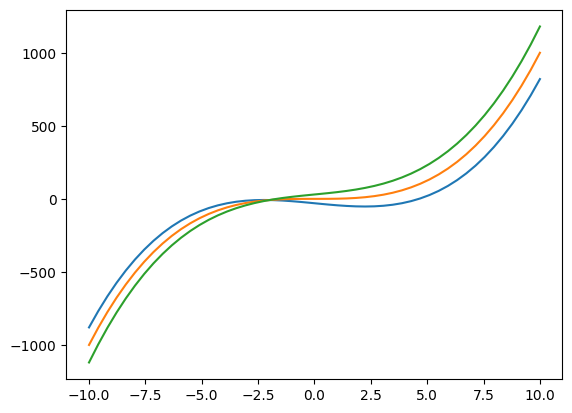

In [43]:
test = lambda x: x[0]**3+0.5*x[0]*x[1]+x[1]+0.2
x = np.linspace(-10,10)
plt.plot(x, [test((a, -30)) for a in x], x, [test((a, 0)) for a in x], x, [test((a, 30)) for a in x])
y0 = [test((a, 0)) for a in x]
np.min(y0) - np.max(y0)

In [144]:
1 is int

<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\Кормак\AppData\Local\Temp\ipykernel_4944\2722025807.py:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  1 is int


False